In [ ]:
import torch
import torch.nn as nn
import os
import math

import numpy as np
import matplotlib.pyplot as plt

direction='in'
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import rc
mpl.rcParams.update({
    'font.family' : 'Arial', #STIXGeneral
    'mathtext.fontset' : 'cm', #stix
    'xtick.direction' : direction ,
    'ytick.direction' : direction ,
    'xtick.labelsize' : 17.5 ,
    'xtick.top' : True ,
    'xtick.major.width' : 1.5,
    'xtick.major.size' : 6,
    'ytick.labelsize' : 17.5 ,
    'ytick.right' : True ,
    'ytick.major.width' : 1.5,
    'ytick.major.size' : 6,
    'axes.labelsize' : 18,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 2,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight',
    'axes.linewidth' : 1.5,
})
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns

import sys

print(plt.rcParams['font.family'])

In [21]:
import argparse
def is_non_zero_file(fpath, verb=False):
    if verb: 
        if os.path.isfile(fpath)==False: print('No', fpath)
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0
def get_arguments():
    parser = argparse.ArgumentParser()
    parser.add_argument("-set", help = "set size", type = int, default = None)
    parser.add_argument("-p1", help = "prob 1", type = float, default = 0.000)
    parser.add_argument("-p2", help = "prob 2", type = float, default = 0.300)
    parser.add_argument("-nr", help = "height", type = int, default = 6)
    parser.add_argument("-nc", help = "width", type = int, default = 6)

    parser.add_argument("-prefix", help = "prefix", type = str, default = '~/QuAN')
    parser.add_argument("-saveprefix", help = "save folder prefix", type = str, default = 'g2_saved_models_tc')
    parser.add_argument("-epoch", help = "total epochs", type = int, default = 100)
    parser.add_argument("-batchsize", type=int, default=50) 

    parser.add_argument("-modelnum", type = str, default = 'p11')
    parser.add_argument("-hdim", type = int, default = 16)
    parser.add_argument("-nhead", type = int, default = 4)
    parser.add_argument("-ch", type = int, default = 1)
    parser.add_argument("-ker", type = int, default = 1)
    parser.add_argument("-st", type = int, default = 1)
    parser.add_argument("-dim_outputs", type=int, default=1)
    parser.add_argument("-p_outputs", type=int, default=1)

    parser.add_argument("-lr", type = float, default = 1e-4)
    parser.add_argument("-lrn", type = int, default = 0)
    parser.add_argument("-optim", type = str, default = None)
    parser.add_argument("-prev", type = str, default = None)
    
    parser.add_argument("-wandb_name", type = str)
    parser.add_argument("-debug", action='store_true', default=False)
    parser.add_argument("-testonly", action='store_true',default=True)

    parser.add_argument("-shuffle_epoch", type=int, default=1, help='shuffling dataset every n epoch')
    parser.add_argument("-nprandseed", action='store_true', default=False, help='random seed fix?')
    args = parser.parse_args(args=[])

    return args
args = get_arguments()

In [4]:
nt=36
def gen_data_loop_topvsinc_all(args, bxbz, inc, verb=False):
    path = f'~/QuAN/Data_src/toric_code/data{args.nr*args.nc}/testing_pflip_{inc:.3f}'
    n_bitstring = 8134//args.set * args.set

    bx, bz = bxbz
    if bz!=0.14: print(f'** Error! ** {bz} != 0.14')

    datafilename = path+f'/betaX={bx:.2f}_betaZ={bz:.2f}_height=300_run=1_width=1000.npz'
    if is_non_zero_file(datafilename):
        a = np.load(datafilename)['arr0'].astype(bool)
        x1 = a[:n_bitstring].reshape(1, n_bitstring, nt)
        x1 = x1.reshape(x1.shape[0]*int(x1.shape[1]/args.set), args.set, nt)
        if verb:
            print(f'gen_data_loop_topvsinc_all,', f'shape: {x1.shape}', \
                  f'bx, bz, pflip = {bx},{bz},{inc}')
        return x1
    else: 
        if verb: print('No file', datafilename)
        return np.zeros(1)

In [3]:
class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        if ln:
            self.ln0 = nn.LayerNorm(dim_V, elementwise_affine=False)
            self.ln1 = nn.LayerNorm(dim_V, elementwise_affine=False)
        self.fc_o = nn.Linear(dim_V, dim_V)
        self.sig = nn.Sigmoid()
        
    def forward(self, Q, K):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)
        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)
        
        A = torch.softmax(Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V), 2)
        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + self.sig(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        return O
    
class SAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, ln=False):
        super(SAB, self).__init__()
        self.mab = MAB(dim_in, dim_in, dim_out, num_heads, ln = ln)
        
    def forward(self, X):
        return self.mab(X, X)
    
class PMA(nn.Module):
    def __init__(self, dim, num_heads, num_seeds, ln = False):
        super(PMA, self).__init__()
        self.S = nn.Parameter(torch.Tensor(1, num_seeds, dim))
        nn.init.xavier_uniform_(self.S)
        self.mab = MAB(dim, dim, dim, num_heads, ln = ln)
        
    def forward(self, X):
        return self.mab(self.S.repeat(X.size(0), 1, 1), X)
    
    
########################################################################

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

class QuAN2(nn.Module):
    def __init__(self, set_size, channel, dim_output,
                 kersize, stride, dim_hidden, num_heads, Nr, Nc, p_outputs,  ln=True):
        super(QuAN2,self).__init__()
        self.Ch = channel
        self.ks = kersize
        self.st = stride
        self.Nr = Nr
        self.Nc = Nc
        self.set_size = set_size
        self.rNr = int((Nr - self.ks)/self.st + 1)
        self.rNc = int((Nc - self.ks)/self.st + 1)
        self.sig = nn.Sigmoid()

        self.enc = nn.Sequential(
                nn.Linear(self.Ch*self.rNr*self.rNc, 3*dim_hidden),
                nn.Sigmoid(),
                nn.Linear(3*dim_hidden, dim_hidden),
                nn.Sigmoid(),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln)
                )
        
        self.dec = nn.Sequential(
                PMA(dim_hidden, num_heads, p_outputs, ln=ln),
                nn.Linear(dim_hidden, dim_output),
                nn.Sigmoid())

    def forward(self, X):
        X = X.view(-1, self.set_size, self.Ch*self.rNr*self.rNc)
        X = self.sig(self.enc(X))
        return self.dec(X)[:,0]

class PAB(nn.Module):
    def __init__(self, set_size, channel, dim_output,
                 kersize, stride, dim_hidden, num_heads, Nr, Nc,  p_outputs, ln=True):
        super(PAB, self).__init__()
        self.Ch = channel
        self.ks = kersize
        self.st = stride
        self.Nr = Nr
        self.Nc = Nc
        self.set_size = set_size
        self.rNr = int((Nr - self.ks)/self.st + 1)
        self.rNc = int((Nc - self.ks)/self.st + 1)
        self.sig = nn.Sigmoid()

        self.enc = nn.Sequential(
                nn.Linear(self.Ch*self.rNr*self.rNc, 3*dim_hidden),
                nn.Sigmoid(),
                nn.Linear(3*dim_hidden, dim_hidden),
                nn.Sigmoid())

        self.dec = nn.Sequential(
                PMA(dim_hidden, num_heads, p_outputs, ln=ln),
                nn.Linear(dim_hidden, dim_output),
                nn.Sigmoid())

    def forward(self, X):
        X = X.view(-1, self.set_size, self.Ch*self.rNr*self.rNc)
        return self.dec(self.enc(X))[:,0]

class Set_MLP(nn.Module):
        def __init__(self, set_size, channel, dim_output,
                     kersize, stride, dim_hidden, Nr, Nc, ln=True):
            super(Set_MLP, self).__init__()
            self.Ch = channel
            self.ks = kersize
            self.st = stride
            self.Nr = Nr
            self.Nc = Nc
            self.set_size = set_size
            self.rNr = int((Nr - self.ks)/self.st + 1)
            self.rNc = int((Nc - self.ks)/self.st + 1)
            self.sig = nn.Sigmoid()

            self.enc = nn.Sequential(
                    nn.Linear(self.Ch*self.rNr*self.rNc, 3*dim_hidden),
                    nn.Sigmoid(),
                    nn.Linear(3*dim_hidden, dim_hidden),
                    nn.Sigmoid())
            self.dec = nn.Sequential(
                    nn.Linear(dim_hidden, dim_hidden),
                    nn.Sigmoid(),
                    nn.Linear(dim_hidden, dim_output))
        def forward(self, X):
            X = X.view(-1, self.set_size, self.Ch*self.rNr*self.rNc)
            X = self.enc(X)
            X = self.dec(X)
            return self.sig(X.sum(axis=1))


In [16]:
class MAB_plot(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, load, ln=True):
        super(MAB_plot, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        if ln:
            self.ln0 = nn.LayerNorm(dim_V, elementwise_affine=False)
        self.fc_o = nn.Linear(dim_V, dim_V)
        self.sig = nn.Sigmoid()
        
        self.fc_q = load.fc_q
        self.fc_k = load.fc_k
        self.fc_v = load.fc_v
        self.ln0 = load.ln0
        self.fc_o = load.fc_o
        self.sig = load.sig
        
    def forward(self, Q, K):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)
        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)
        
        A = torch.softmax(Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V), 2)
        O = torch.cat((A.bmm(V_)).split(Q.size(0), 0), 2)
        O0 = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O1 = O0 if getattr(self, 'ln0', None) is None else self.ln0(O0)
        O2 = self.sig(self.fc_o(O1))
        O3 = O1 + O2
        return O, O0, O1, O2, O3

In [15]:
def load_model(train_setsize, test_setsize, nh, run):
    args = get_arguments()
    p2train=0.300
    args.dataformat='loop'
    args.set = test_setsize
    args.modelnum = 'p01'
    args.run = run
    args.batchsize = 2048
    args.dim_outputs = 1
    args.nhead = nh
    args.wandb_name = f'TC_{args.modelnum}_0.000vs{p2train:.3f}_5_run_{args.run}'
    modelname= f'model_e_{args.nr}x{args.nc}_0.000vs{p2train:.3f}-{args.modelnum}_set{train_setsize}_h16nh{nh}_ch1ker1st1.pth'
    args.prev = modelname
    model = PAB(set_size=test_setsize, channel=args.ch, dim_output=args.dim_outputs, \
                                   kersize=args.ker, stride=args.st, dim_hidden=args.hdim, num_heads=args.nhead, \
                                   Nr=args.nr, Nc=args.nc, p_outputs=args.p_outputs)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    modelloadname = f'Data_out/g2_saved_models_tc/{args.wandb_name}/{args.prev}'
    if not is_non_zero_file(modelloadname): print('No', modelloadname), sys.exit()
    state_dict = torch.load(modelloadname, \
                            map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()
    return args, model

def plot_loopcurve_attention_percentile_crude(args, model, nh):
    
    p2datas = [0.050, 0.075, 0.100, 0.125]
    c_arr = []; x_arr = []; y_arr = []
    for i_p, p2data in enumerate(p2datas):
        args.p2 = p2data
        bx, bz, pflip = 0, 0.14, p2data
        x1_bxbz = gen_data_loop_topvsinc_all(args, (bx,bz), pflip, verb=True)
        xt_ = torch.from_numpy(x1_bxbz)
        xx = model.enc(xt_.float())
        outputt = model(xt_.float())
        y_arr.append(outputt[:,0].detach().numpy())

        ss = model.dec[0].S.repeat(xx.size(0), 1, 1)
        a0 = model.dec[0].mab.fc_q(ss).data.numpy().reshape(x1_bxbz.shape[0], -1, nh, 16//nh)
        b0 = model.dec[0].mab.fc_k(xx).data.numpy().reshape(x1_bxbz.shape[0], -1, nh, 16//nh)

        c0 = np.zeros((ss.shape[0], a0.shape[1], b0.shape[1], nh))
        for k in range(c0.shape[0]):
            for i in range(c0.shape[1]):
                for j in range(c0.shape[2]):
                    for l in range(nh):
                        c0[k, i,j, l]= np.exp(np.dot(a0[k, i, l], b0[k, j, l]))
                c0[k, i] = (c0[k, i]/np.sum(c0[k, i], axis=0))
        c_arr.append(c0)
        x_arr.append(x1_bxbz)
    
    return model, x_arr, y_arr, c_arr

def exp(x, a, b,c):
    return a*np.exp(b*x) + c
def exp_loop(array, maxL):
    arr = np.zeros(maxL)
    array = array.reshape(6,6)*2-1
    for L in range (1,maxL+1):
        loop = 0
        for i in range(array.shape[0]-L+1):
            for j in range(array.shape[1]-L+1):
                loop += np.prod(array[i:i+L, j:j+L])
        arr[L-1] = loop/((i+1)*(j+1))
    return arr

In [ ]:
p2train=0.300
p2datas = [0.050, 0.075, 0.100, 0.125]
nh=4
run=3
args, model = load_model(32, 64, nh, run)
model, x_arr, y_arr, c_arr = plot_loopcurve_attention_percentile_crude(args, model, nh)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Arial']
(10, 36) (10, 36)
(10, 36) (10, 36)


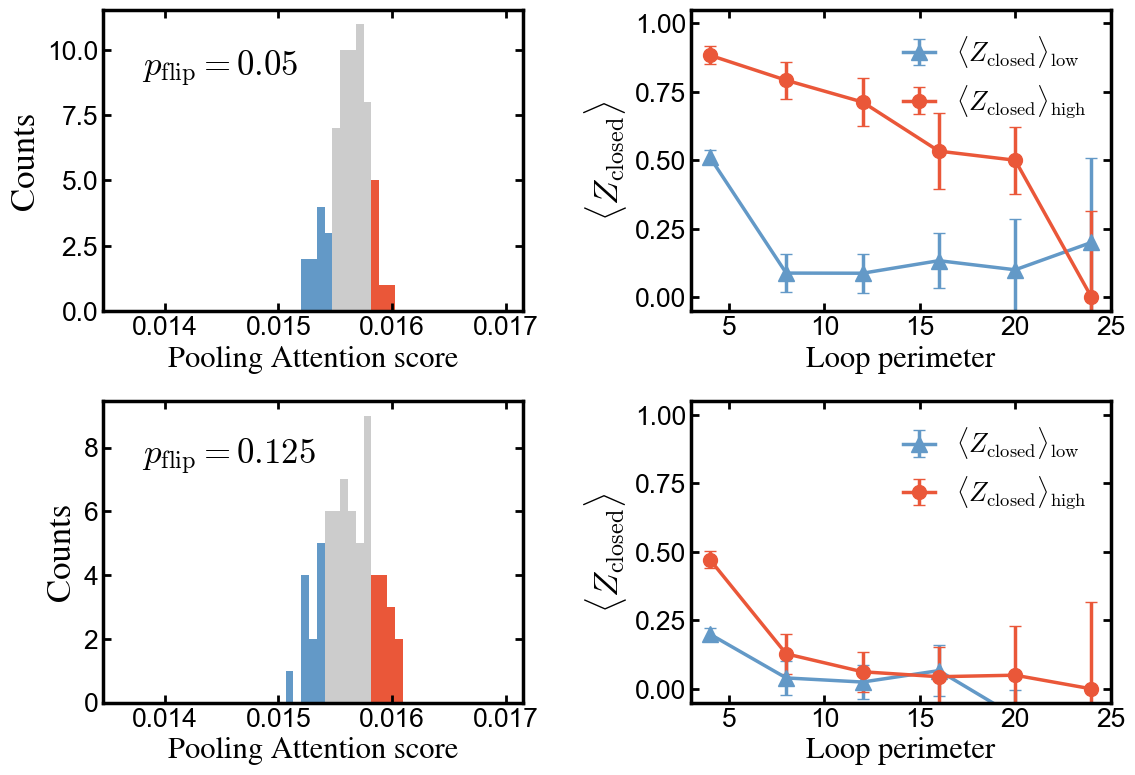

In [321]:
print(plt.rcParams['font.family'])

cm = plt.cm.get_cmap('RdYlBu_r')
mpl.rcParams['axes.linewidth'] = 2.5

cmap = ['#ea5739', '#edeb5f', '#6399c7']

i_p=0
mask = np.zeros(127).astype(bool);  mask[116]=True
binnum = 50
for n_nh in [3]:
    fig, ax = plt.subplots(2,2, figsize=(13*1.0, 9*1.0))
    cmin, cmax = np.array(c_arr).min(), np.array(c_arr).max()
    for i,i_p in enumerate([0,3]):
        if i==0: nset = 116
        else: nset = 43
        a = 15; b = 85
        cut1, cut2 = np.percentile(c_arr[i_p][nset,0,:,n_nh], a), np.percentile(c_arr[i_p][nset,0,:,n_nh], b)
        mask1 = c_arr[i_p][nset,0,:,n_nh]<cut1
        mask3 = c_arr[i_p][nset,0,:,n_nh]>cut2
        list1 = x_arr[i_p][nset][mask1]
        list3 = x_arr[i_p][nset][mask3]

        N, bins, patches = ax[i,0].hist(c_arr[i_p][mask, 0, :, n_nh].reshape(-1), \
                                        bins=np.linspace(cmin,cmax,binnum), \
                                         color='#cccccc')
        for bini in range(binnum-1):
            if bins[bini]<cut1: patches[bini].set_facecolor(cmap[2])
            elif bins[bini]>cut2: patches[bini].set_facecolor(cmap[0])
            else: continue

        ax[i,0].legend(loc=3)

        print(list1.shape, list3.shape)
        loopavg1 = np.array([exp_loop(list1[j], 6) for j in range(list1.shape[0])])
        loopavg3 = np.array([exp_loop(list3[j], 6) for j in range(list3.shape[0])])
        ax[i,1].errorbar(np.arange(6)*4+4, loopavg1.mean(axis=0), \
                         yerr=loopavg1.std(axis=0)/np.sqrt(loopavg1.shape[0]),\
                         fmt='^-', capsize=4, lw=2.5, ms=12, c=cmap[2], label=r'$\langle Z_\mathrm{closed}\rangle_\mathrm{low}$')
        ax[i,1].errorbar(np.arange(6)*4+4, loopavg3.mean(axis=0), \
                         yerr=loopavg3.std(axis=0)/np.sqrt(loopavg3.shape[0]),\
                         fmt='o-', capsize=4, lw=2.5, ms=10, c=cmap[0], label=r'$\langle Z_\mathrm{closed}\rangle_\mathrm{high}$')

        ax[i,1].set_ylim(-0.05, 1.05)
    ax[0,1].legend(loc=1, handlelength=1.2, fontsize=19)
    ax[1,1].legend(loc=1, handlelength=1.2, fontsize=19)


    ax[0,0].set_ylabel('Counts', fontsize=25, font='STIXGeneral')
    ax[1,0].set_ylabel('Counts', fontsize=25, font='STIXGeneral')
    ax[0,0].set_xlabel(r'Pooling Attention score', fontsize=22, font='STIXGeneral')
    ax[1,0].set_xlabel(r'Pooling Attention score', fontsize=22, font='STIXGeneral')
    ax[0,1].set_ylabel(r'$\langle Z_\mathrm{closed}\rangle$', fontsize=25, font='STIXGeneral')
    ax[1,1].set_ylabel(r'$\langle Z_\mathrm{closed}\rangle$', fontsize=25, font='STIXGeneral')
    ax[0,1].set_xlabel('Loop perimeter', fontsize=22, font='STIXGeneral')
    ax[1,1].set_xlabel('Loop perimeter', fontsize=22, font='STIXGeneral')

    ax[0,0].tick_params(axis='both', which='major', labelsize=19)
    ax[1,0].tick_params(axis='both', which='major', labelsize=19)
    ax[0,1].tick_params(axis='both', which='major', labelsize=19)
    ax[1,1].tick_params(axis='both', which='major', labelsize=19)

    plt.subplots_adjust(hspace=.3, wspace=.4)
    for a in ax.flatten():
        a.xaxis.set_tick_params(width=2)
        a.yaxis.set_tick_params(width=2)
    ax[0,0].text(0.0138, 9, r'$p_\mathrm{flip}=0.05$', fontsize=25)
    ax[1,0].text(0.0138, 7.5, r'$p_\mathrm{flip}=0.125$', fontsize=25)
    plt.savefig('fig4f.png', dpi=300)

In [289]:
mpl.rcParams.update({
    'font.family' : 'Arial', #STIXGeneral
    'mathtext.fontset' : 'cm', #stix
    'xtick.direction' : direction ,
    'ytick.direction' : direction ,
    'xtick.labelsize' : 17.5 ,
    'xtick.top' : True ,
    'xtick.major.width' : 1.5,
    'xtick.major.size' : 6,
    'ytick.labelsize' : 17.5 ,
    'ytick.right' : True ,
    'ytick.major.width' : 1.5,
    'ytick.major.size' : 6,
    'axes.labelsize' : 18,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 2,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight',
    'axes.linewidth' : 1.5,
})

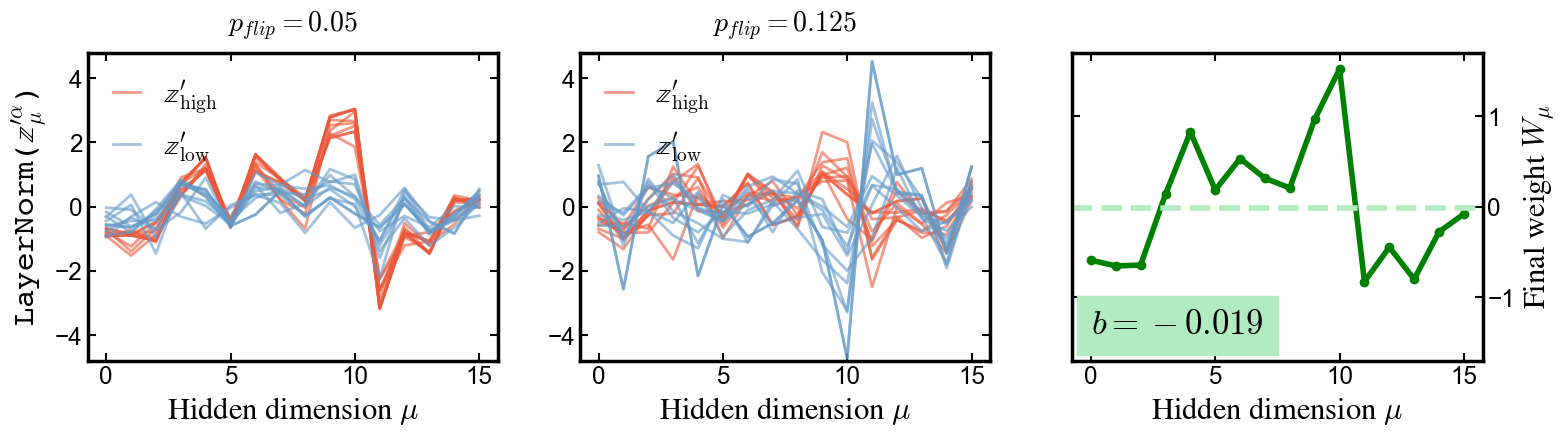

In [393]:
fig, ax = plt.subplots(1,3, figsize=(18,4), sharex='row')#, gridspec_kw={'width_ratios': [1.2, 1, 1, 1]})

i_p = 0
nset = 116
X = model.enc(torch.from_numpy(np.array(x_arr)).float())
Z = (model.dec[0].mab.fc_v(X) + model.dec[0].mab.fc_q(model.dec[0].S)[0]).detach().numpy().reshape(-1, 127, 64, 16)
mab_plot = MAB_plot(16, 16, 16, 4, load=model.dec[0].mab)
O, O0, O1, O2, O3 = mab_plot(model.dec[0].S.repeat(X.shape[0]*X.shape[1], 1, 1), X.view(-1, 64, 16))
O0 = O0.detach().numpy().reshape(-1, 127, 16)
Z = (Z - Z.mean(axis=(2,3)).reshape(-1, 127, 1, 1)) / Z.std(axis=(2,3)).reshape(-1, 127, 1, 1)

cmap = ['#ea5739', '#edeb5f', '#6399c7']

i_p = 0
nset = 116
a,b = 15,85
cut1, cut2 = np.percentile(c_arr[i_p][nset,0,:,n_nh], a), np.percentile(c_arr[i_p][nset,0,:,n_nh], b)
mask1 = c_arr[i_p][nset,0,:,n_nh]<cut1
mask3 = c_arr[i_p][nset,0,:,n_nh]>cut2
for j in range(mask3.sum()):
    ax[0].errorbar(np.arange(16), Z[i_p, nset, mask3][j], lw=2, c=cmap[0], alpha=.6)
    if j==0:
        ax[0].errorbar(np.arange(16), Z[i_p, nset, mask3][j], lw=2, c=cmap[0], alpha=.6, \
                       label=r'$\mathbb{z}^\prime_\mathrm{high}$')
    
for j in range(mask1.sum()):
    ax[0].errorbar(np.arange(16), Z[i_p, nset, mask1][j], lw=2, c=cmap[2], alpha=.6)
    if j==0:
        ax[0].errorbar(np.arange(16), Z[i_p, nset, mask1][j], lw=2, c=cmap[2], alpha=.6, \
                       label=r'$\mathbb{z}^\prime_\mathrm{low}$')

i_p = 3
nset = 43
cut1, cut2 = np.percentile(c_arr[i_p][nset,0,:,n_nh], a), np.percentile(c_arr[i_p][nset,0,:,n_nh], b)
mask1 = c_arr[i_p][nset,0,:,n_nh]<cut1
mask3 = c_arr[i_p][nset,0,:,n_nh]>cut2
for j in range(mask3.sum()):
    ax[1].errorbar(np.arange(16), Z[i_p, nset, mask3][j]/1.2, lw=2, c=cmap[0], alpha=.6)
    if j==0:
        ax[1].errorbar(np.arange(16), Z[i_p, nset, mask3][j]/1.2, lw=2, \
                       c=cmap[0], alpha=.6, label=r'$\mathbb{z}^\prime_\mathrm{high}$')
for j in range(mask1.sum()):
    ax[1].errorbar(np.arange(16), Z[i_p, nset, mask1][j]/1.2, lw=2, c=cmap[2], alpha=.6)
    if j==0:
        ax[1].errorbar(np.arange(16), Z[i_p, nset, mask1][j]/1.2, lw=2, \
                       c=cmap[2], alpha=.6, label=r'$\mathbb{z}^\prime_\mathrm{low}$')

ax[0].set_ylim(-4.8, 4.8)
ax[0].legend(loc=2, handlelength=1, fontsize=20)
ax[1].set_ylim(-4.8, 4.8)
ax[1].legend(loc=2, handlelength=1, fontsize=20)

ax[0].set_ylabel(r'LayerNorm($\mathbb{z}^{\prime\alpha}_\mu$)', fontsize=22, font='courier')
ax[0].set_xlabel(r'Hidden dimension $\mu$', fontsize=22, font='STIXgeneral')
ax[1].set_xlabel(r'Hidden dimension $\mu$', fontsize=22, font='STIXgeneral')

ax[0].set_title(r'$p_{flip}=$'+fr'${p2datas[0]}$', fontsize=20, pad=15)
ax[1].set_title(r'$p_{flip}=$'+fr'${p2datas[3]}$', fontsize=20, pad=15)

W = model.dec[1].weight.detach().numpy()
for i in range(3):
    if i!=2: continue
    ax[i].plot(W[0], 'go-', lw=4)
    ax[i].set_xlabel(r'Hidden dimension index $\mu$', fontsize=22, font='STIXgeneral')
    ax[i].set_ylabel(r'Final weight $W_\mu$', fontsize=22, font='STIXgeneral')
ax[2].set_ylim(-1.7, 1.7)
ax[2].yaxis.set_label_position('right')
ax[2].yaxis.tick_right()
ax[2].yaxis.set_ticks_position('both')
ax[2].text(0,-1.4, fr'$b={model.dec[1].bias.detach().numpy()[0]:.3f}$',\
           backgroundcolor='#b2ebbf', fontsize=25, font='STIXGeneral')
ax[2].axhline(model.dec[1].bias.detach().numpy()[0], ls='--',lw=4, c='#b2ebbf')
plt.subplots_adjust(wspace=.2)
plt.savefig('fig_sup_E_encout.png', dpi=300, transparent=True, bbox_inches='tight')